### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from yellowbrick.regressor import PredictionError
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import StratifiedKFold

### Load data

In [4]:
datasets = []
for filename in os.listdir('Results'):
    dataset = pd.read_csv(os.path.join('Results', filename))
    dataset.columns = dataset.columns.str.strip()
    datasets.append((filename, dataset))
dataset.head()

,range,n1,average1,median1,std1,n2,average2,median2,std2,time
0,34109.0,22,56643.227273,59553.5,9248.859472,22,56643.227273,59553.5,9248.859472,120
1,65216.0,22,56643.227273,59553.5,9248.859472,1917,31563.412624,30600.0,19041.011288,1104
2,65391.0,22,56643.227273,59553.5,9248.859472,565,30944.711504,31444.0,18752.317665,459
3,34109.0,22,56643.227273,59553.5,9248.859472,6,45602.500000,45602.5,1.707825,102
4,65415.0,22,56643.227273,59553.5,9248.859472,1472,32220.092391,31440.0,19215.933452,866


### Shape datasets

In [39]:
#feature_cols = ['range', 'n1', 'average1', 'median1' , 'std1', 'n2', 'average2', 'median2', 'std2']

In [64]:
feature_cols = ['n1', 'n2']

In [65]:
# All rows, and the feature_cols' columns
Xs = []
for (filename, dataset) in datasets:
    X = dataset.loc[:, feature_cols]
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    Xs.append(X)
X.shape

(47742, 2)

In [66]:
ys = []
for (filename, dataset) in datasets:
    y = dataset.loc[:, 'time']
    ys.append(y)
y.shape

(47742,)

In [67]:
sets = []
for index,(filename, dataset) in enumerate(datasets):  
    X_train, X_test, y_train, y_test = train_test_split(Xs[index], ys[index], test_size=0.2, random_state=0)
    sets.append((X_train, X_test, y_train, y_test, filename))
"train: " + str(y_train.shape) + " test: " + str(y_test.shape)

'train: (38193,) test: (9549,)'

# Regression

### Train regression model

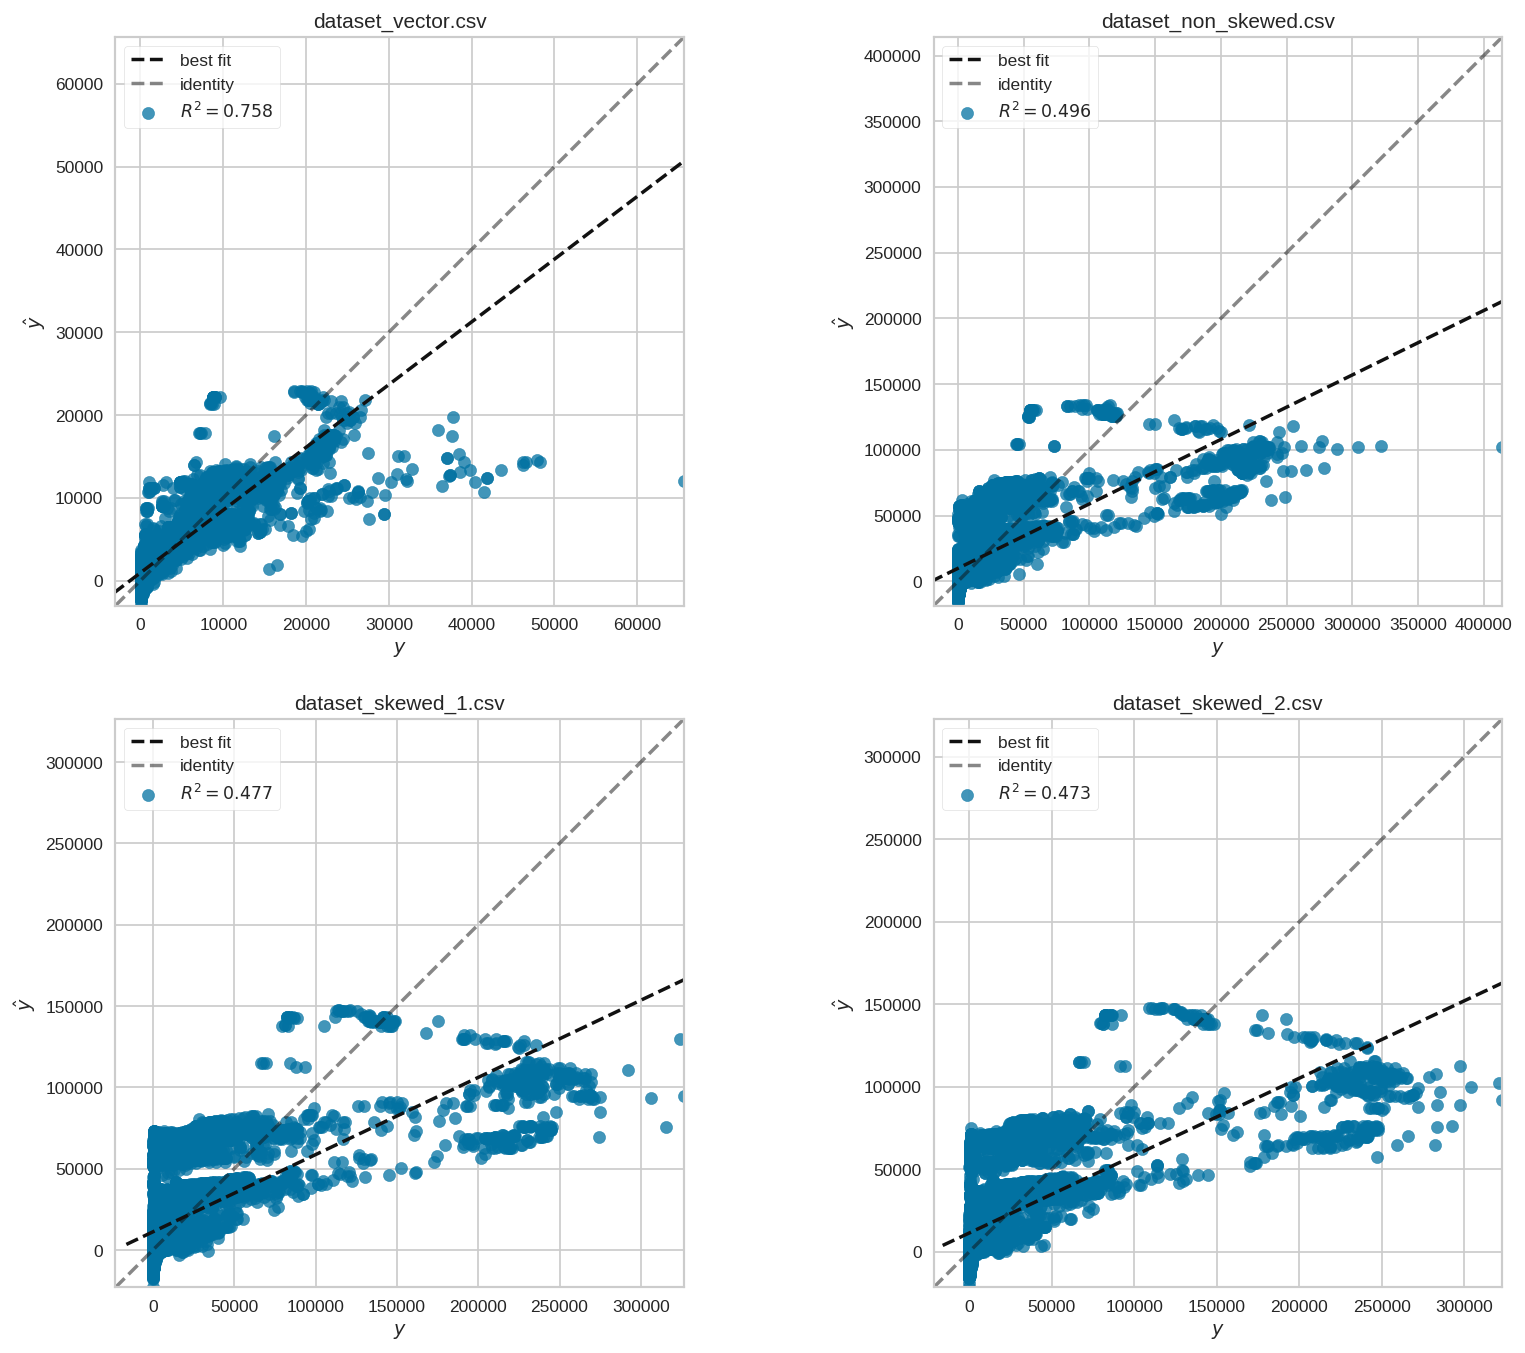

In [59]:
fig = plt.figure()
fig.subplots_adjust(bottom= 1, top= 3.5, left=1, right=3)
for index, (X_train, X_test, y_train, y_test, filename) in enumerate(sets):
    ax = fig.add_subplot(2,2,index+1)
    
    visualizer = PredictionError(LinearRegression(n_jobs=-1), ax=ax)
    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.finalize()
    ax.set_title(filename)
plt.show()

### Regression Feature Importances

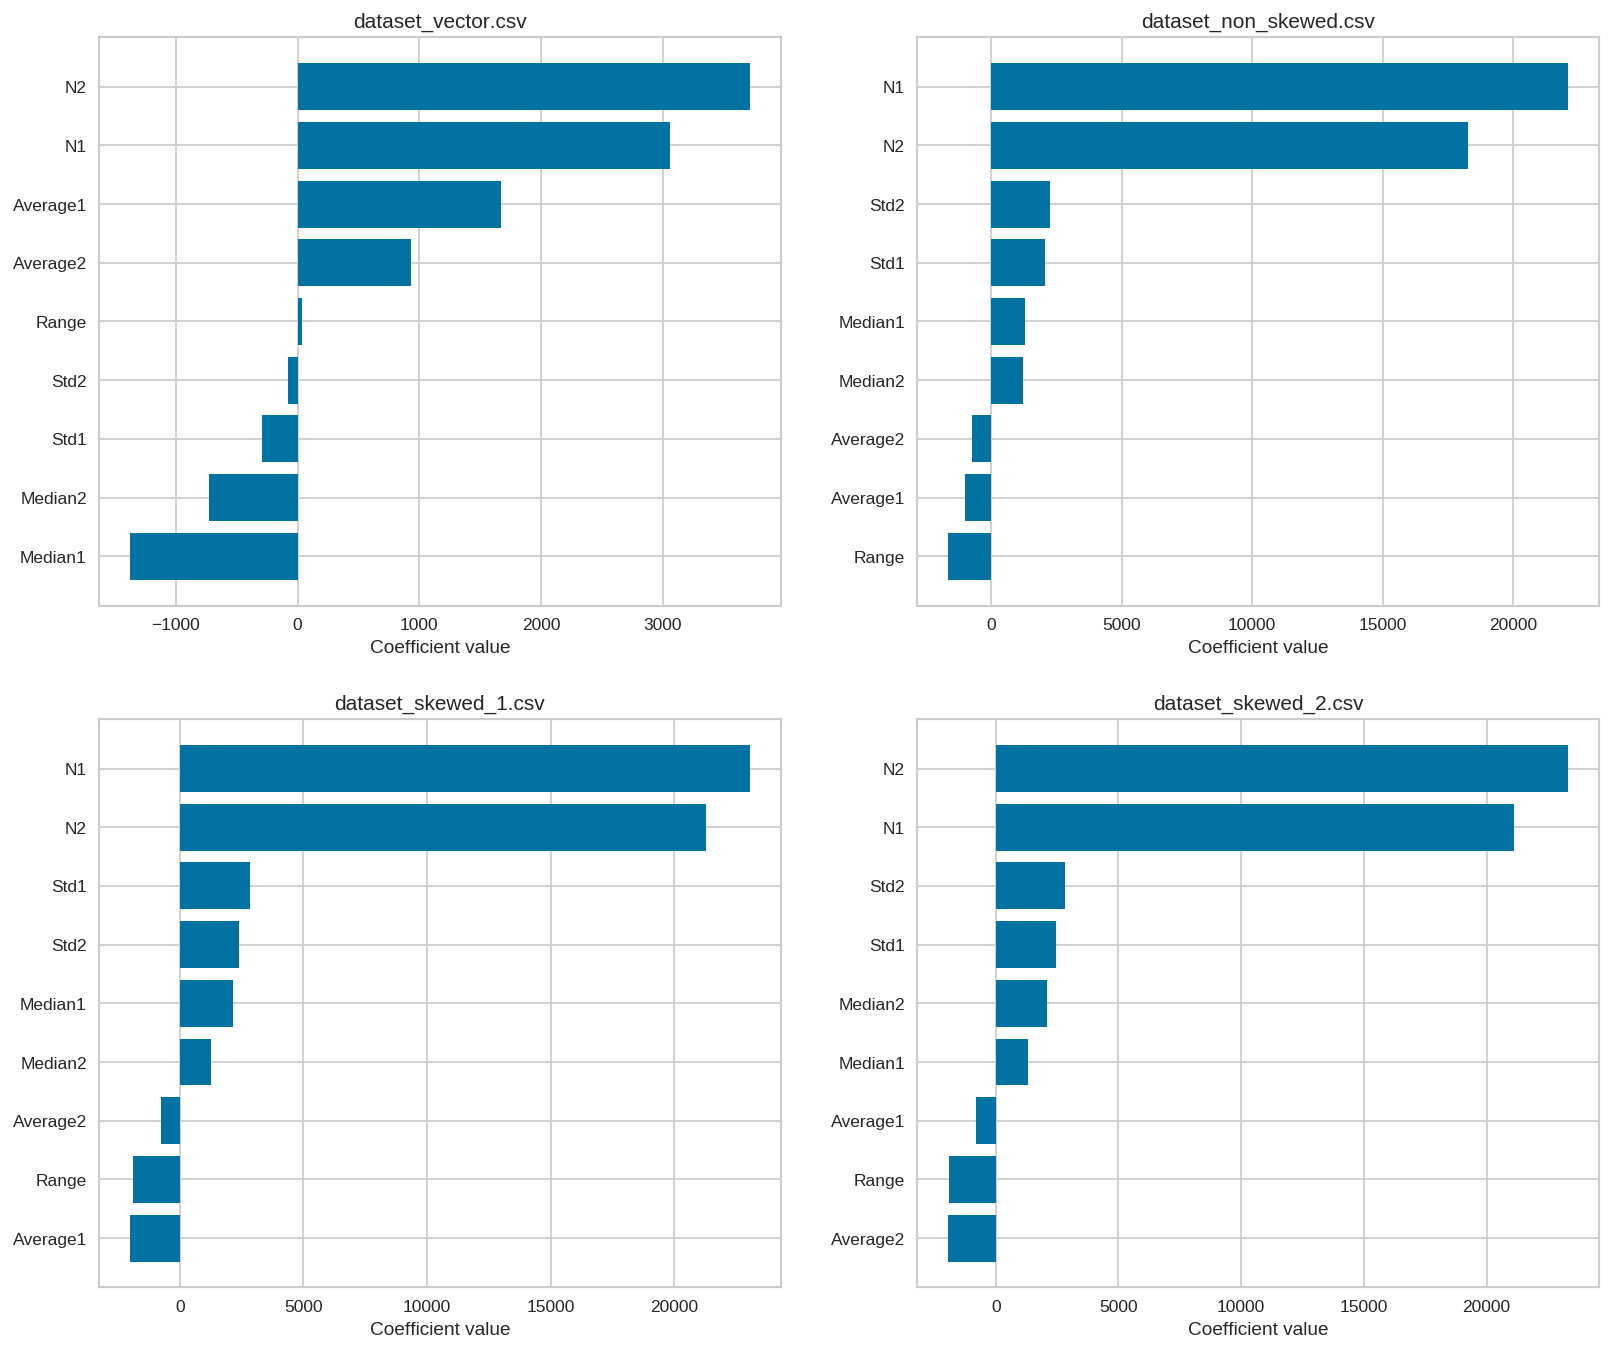

In [44]:
fig = plt.figure()
fig.subplots_adjust(bottom= 1, top= 3.5, left=1, right=3)
for index,(filename, dataset) in enumerate(datasets):
    ax = fig.add_subplot(2,2,index+1)
    labels = list(map(lambda s: s.title(), feature_cols))
    viz = FeatureImportances(LinearRegression(n_jobs=-1), labels=labels, ax=ax, relative=False)
    viz.fit(Xs[index], ys[index])
    ax.set_title(filename)
    ax.set_xlabel("Coefficient value")
plt.show()

### Regression Learning Curve

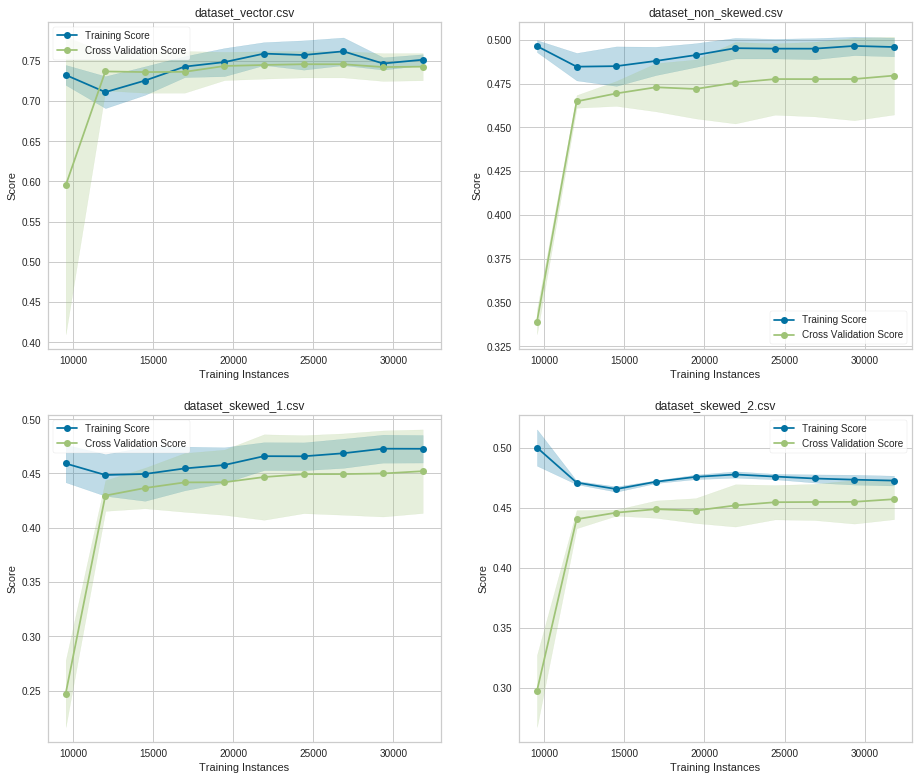

In [17]:
sizes = np.linspace(0.3, 1.0, 10)

fig = plt.figure()
fig.subplots_adjust(bottom= 1, top= 3.5, left=1, right=3)
for index,(filename, dataset) in enumerate(datasets):
    ax = fig.add_subplot(2,2,index+1)
    viz = LearningCurve(LinearRegression(n_jobs=-1), scoring='r2', train_sizes=sizes, n_jobs=4, ax=ax)
    viz.fit(Xs[index], ys[index])
    viz.finalize()
    ax.set_title(filename)
plt.show()

### Regression Validation Curve

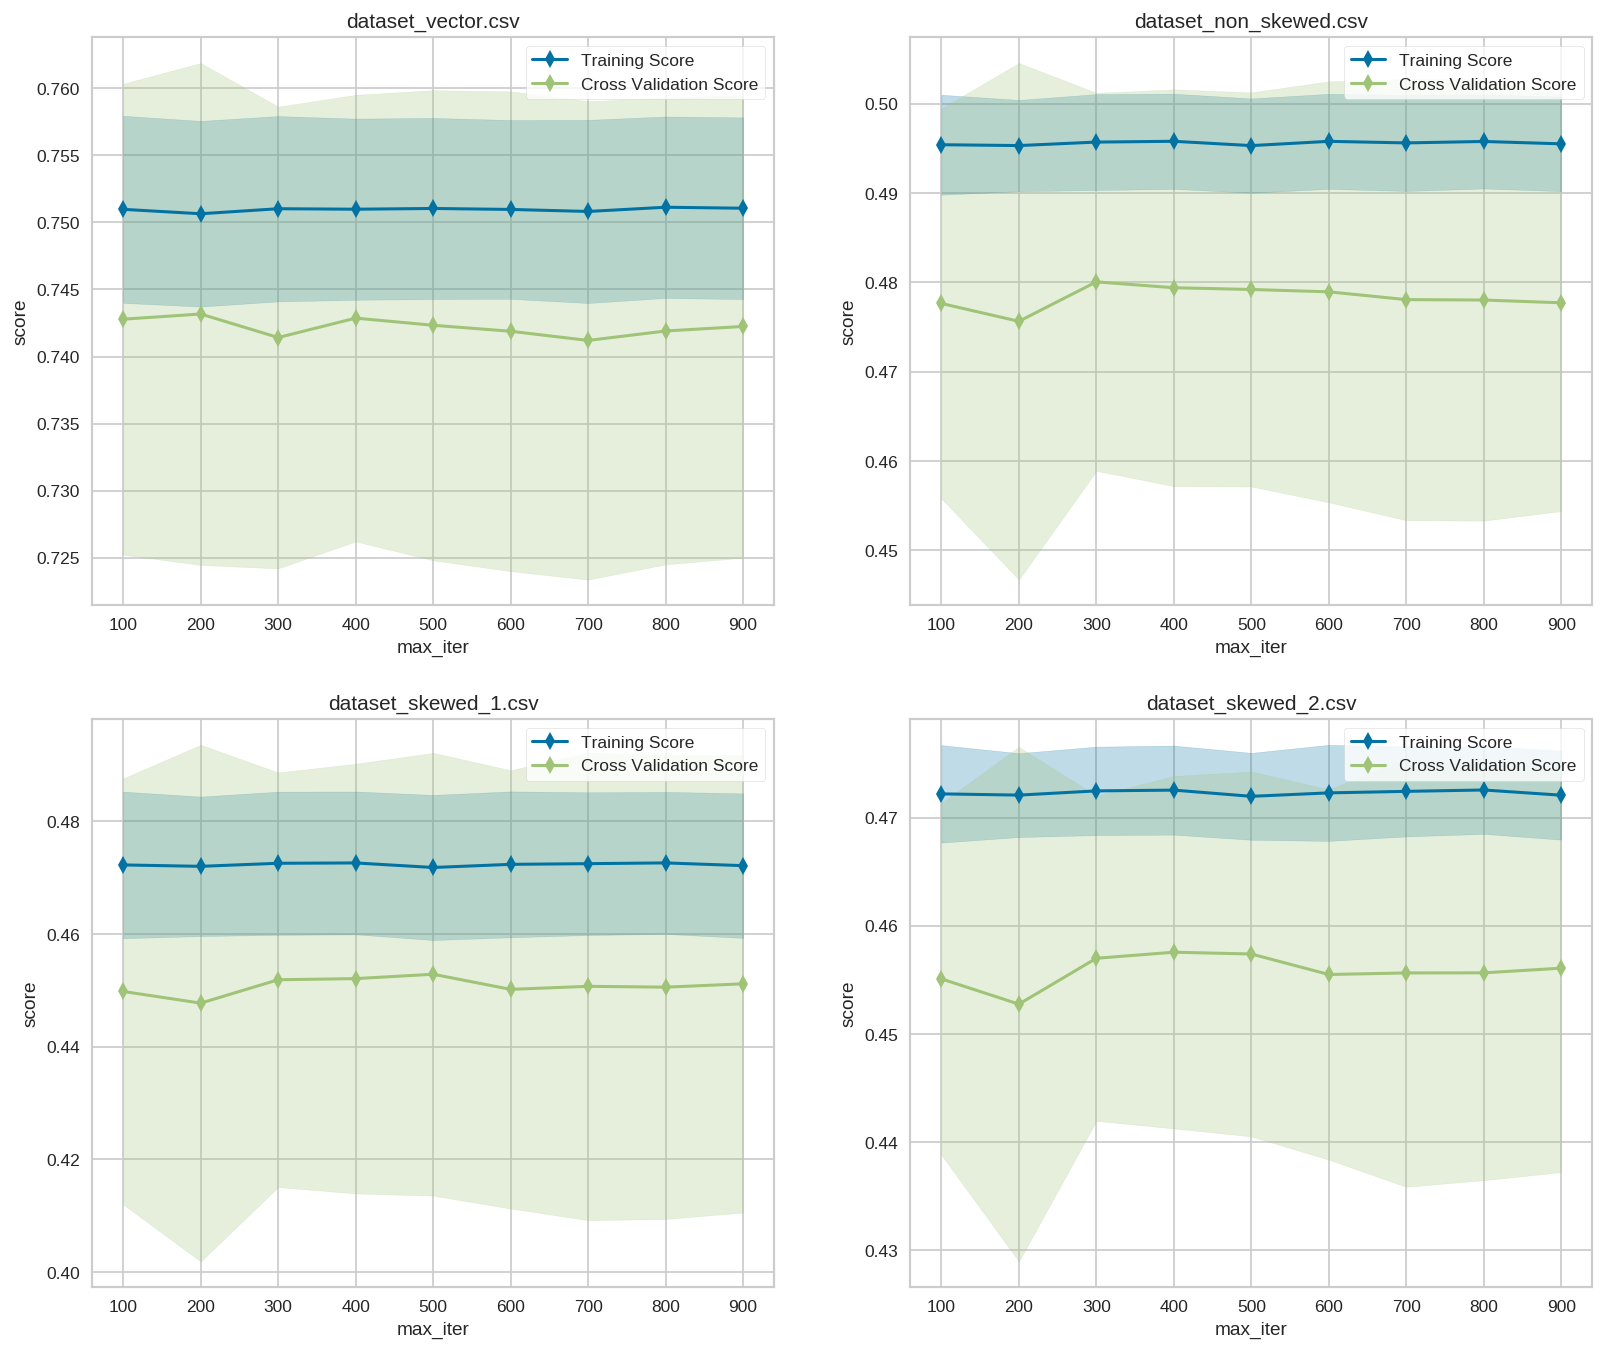

In [32]:
param_range = np.arange(100, 1000, 100)
fig = plt.figure()
fig.subplots_adjust(bottom= 1, top= 3.5, left=1, right=3)
for index,(filename, dataset) in enumerate(datasets):
    ax = fig.add_subplot(2,2,index+1)
    viz = ValidationCurve(
    SGDRegressor(), param_name="max_iter", param_range=param_range,
    scoring="r2", n_jobs=4, ax=ax)
    viz.fit(Xs[index], ys[index])
    viz.finalize()
    ax.set_title(filename)
plt.show()

# Classification

### Build Classification dataset

In [80]:
cy = []
cyTimes = []
for i in range(len(ys[0])):
    minVal = float("inf")
    minName = ""
    for j,(filename, dataset) in enumerate(datasets):
        #removing Vector! too fast compared to other algos
        if (j>0):
            if (minVal > ys[j][i]):
                minVal = ys[j][i]
                minName = filename
    cy.append(minName)
    cyTimes.append(minVal)
cy = np.array(cy)
cy.shape

(47742,)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(Xs[0], cy, test_size=0.2, random_state=0)
"train: " + str(y_train.shape) + " test: " + str(y_test.shape)

'train: (38193,) test: (9549,)'

### Train Classification model

In [70]:
import matplotlib as mpl
plt.rcParams['figure.dpi'] = 125

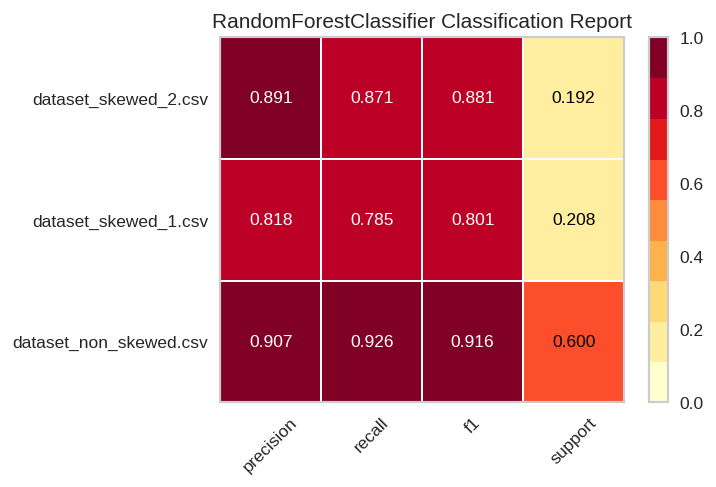

In [77]:
visualizer = ClassificationReport(RandomForestClassifier(n_estimators=5), support='percent')

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

### Confusion Matrix

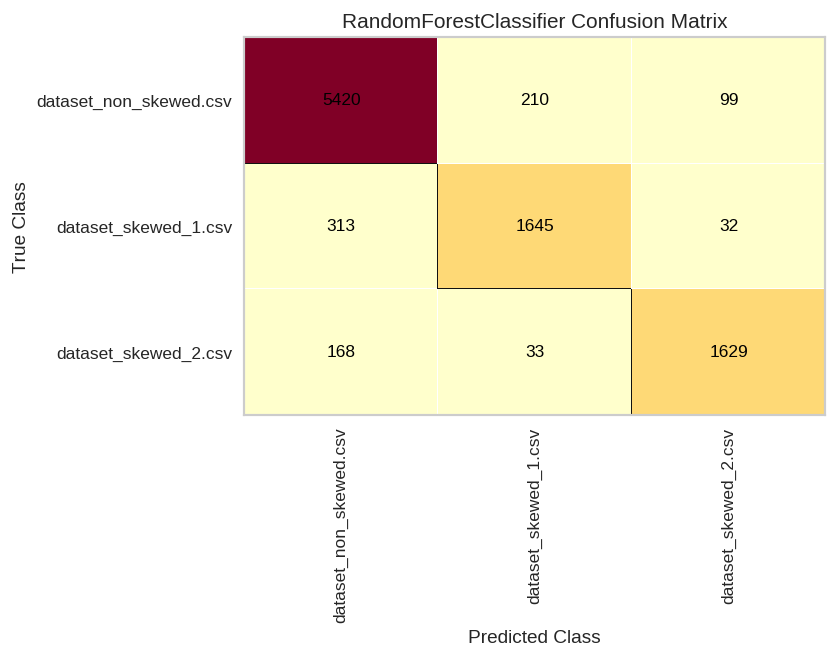

In [53]:
cm = ConfusionMatrix(RandomForestClassifier(n_estimators=15))
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

cm.poof()

### Classification Feature importances

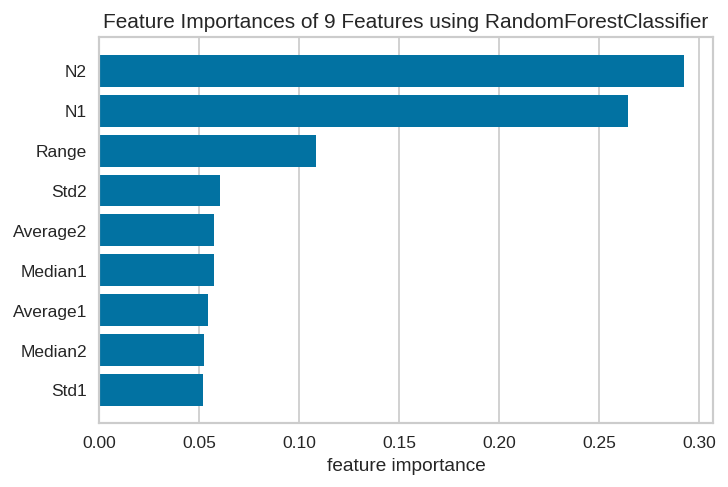

In [54]:
labels = list(map(lambda s: s.title(), feature_cols))
viz = FeatureImportances(RandomForestClassifier(n_estimators=10), labels=labels, relative=False)
viz.fit(Xs[0], cy)
viz.poof()

### Classification learning curve

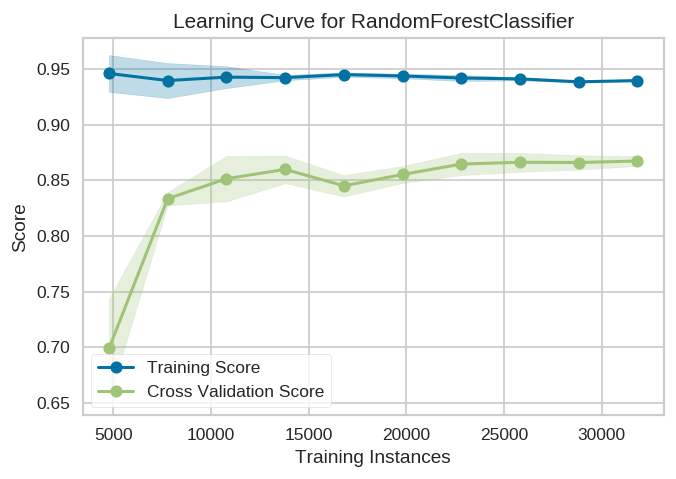

In [38]:
sizes = np.linspace(0.15, 1.0, 10)

viz = LearningCurve(
    RandomForestClassifier(n_estimators=10), train_sizes=sizes,
    scoring='f1_weighted', n_jobs=-1
)

viz.fit(Xs[0], cy)
viz.poof()

### Classification Validation Curve

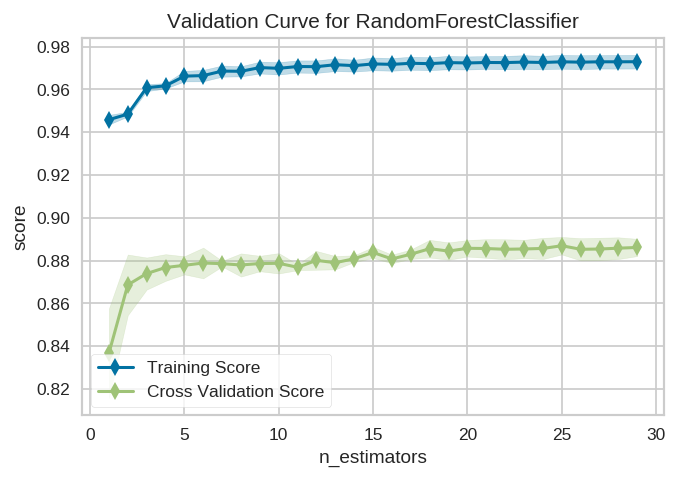

In [25]:
param_range = np.arange(1, 30, 1)

viz = ValidationCurve(
    RandomForestClassifier(), param_name="n_estimators", param_range=param_range,
    scoring="f1_weighted", n_jobs=-1)

viz.fit(Xs[0], cy)
viz.poof()

### Export Classification model to C

In [73]:
from sklearn_porter import Porter

clf = RandomForestClassifier(n_estimators=5)
clf.fit(Xs[0], cy)

porter = Porter(clf, language='c')
output = porter.export(embed_data=True)

with open('forest.c', 'w') as f:
    f.write(output)

In [138]:
benchmarkSet = []

[['n1', 'n2'], 'dataset_vector', 'dataset_non_skewed', 'dataset_skewed_1', 'dataset_skewed_2', 'predictedAlgoTime', 'predictedAlgo']

benchmarkSet.append(Xs[0])

for y in ys:
    benchmarkSet.append(y)
    
benchmarkSet.append(cyTimes)
benchmarkSet.append(cy)


In [139]:
mlTimes = []
osTimes = []

# X_train, X_test, y_train, y_test = train_test_split(benchmarkSet, benchmarkSet, test_size=0.2, random_state=0)

# # for i in benchmarkSet[-1]:
# #     print(i)


#np.random.shuffle(benchmarkSet)
for i in benchmarkSet:
    print(i[0])

clf = RandomForestClassifier(n_estimators=5)
clf.fit(benchmarkSet[0][:-8000], benchmarkSet[-1][:-8000])

mlChosenAlgos = clf.predict(benchmarkSet[0][-8000:])

count = 0
print(mlChosenAlgos[0])
print(benchmarkSet[-1][8000])


for i, algo in enumerate(mlChosenAlgos):
    if(algo == benchmarkSet[-1][8000+i]):
        count += 1
float(count)/len(mlChosenAlgos)
    

[-0.55801899 -0.55669022]
259
129
423
120
120
dataset_skewed_2.csv
dataset_non_skewed.csv
dataset_non_skewed.csv


0.453625